# Transport
In this tutorial we solve a heat transport problem with two wells, one for injection of cold water and one where hot water is produced. We first compute the fluxes $u$ solving a Darcy problem, and then solve the transport problem for the temperature $T$ with and without the diffusive term. <br>

Refer to the tutorial get_started for definitions of geometrical entities, variables and data. As in that example, we choose a unit square domain. For the Darcy problem, we set Dirichlet conditions on the boundary: $\Omega = [0, 1]^2$, $\partial \Omega_d = \partial \Omega$, $\partial \Omega_n = \emptyset$. The boundary value is $p_b = 1000$, whereas the permeability and source term will be defined below. <br>

The transport equation is given by
$$ \frac{\partial T}{\partial t} + u \cdot \nabla T - \nabla \cdot C \nabla T = f_T. $$
$C$ is the (effective) heat conductivity tensor and $f_T$ the heat sources and sinks. The boundary conditions are Dirichlet fixed temperature equal to the initial temperature in the domain. We will use different constant, isotropic values for C and define $f_T$ to be zero except in the two wells. <br>

As usual, we start by importing the required modules:

In [51]:
import numpy as np
import scipy.sparse as sps

from porepy.grids import structured
from porepy.viz.plot_grid import plot_grid
from porepy.params import tensor
from porepy.params.data import Parameters
from porepy.params.bc import BoundaryCondition
from porepy.numerics.fv import tpfa, source, mass_matrix
from porepy.numerics.fv.transport import upwind
from porepy.utils.comp_geom import dist_point_pointset as distance

## Grid creation
We proceed by setting up a cartesian grid:

In [52]:
Nx = Ny = 15                 
g = structured.CartGrid([Nx, Ny], physdims=[15, 15])
g.compute_geometry()

In **PorePy**, tags indicating grid related quantities may be added directly to the dictionary stored as the grid field tags. We will use this to identify cells for subsequent permeability assignment:

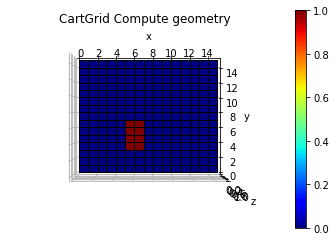

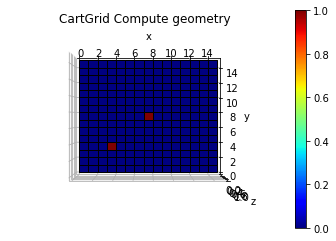

In [53]:
# Pick out the two cells closest to the well locations
i_prod = np.argmin(distance(np.array([4, 4, 0]), g.cell_centers))
i_inj = np.argmin(distance(np.array([8, 8, 0]), g.cell_centers))
g.tags['production_cell'] = np.zeros(g.num_cells, dtype=bool)
g.tags['injection_cell'] = np.zeros(g.num_cells, dtype=bool)
g.tags['production_cell'][i_prod] = 1
g.tags['injection_cell'][i_inj] = 1

# Define a subdomain
Omega_1 = np.ones(g.num_cells, dtype=bool)
Omega_1[g.cell_centers[0, :] < 5] = 0
Omega_1[g.cell_centers[0, :] > 7] = 0
Omega_1[g.cell_centers[1, :] < 3] = 0
Omega_1[g.cell_centers[1, :] > 7] = 0
plot_grid(g, Omega_1)
plot_grid(g, g.tags['production_cell'] + g.tags['injection_cell'])


## Darcy problem data
We now construct the boundary condition object and two different permeability tensors, and assign parameters. Once again, we refer to get_started for more detailed explanations.

In [64]:
# Permeability

k = 1e-2 * np.ones(g.num_cells)
k[Omega_1] = 1e-5
perm = tensor.SecondOrder(3, k)                              

f_flow = np.zeros(g.num_cells)
injection_volume = 10
production_volume = - injection_volume
f_flow[g.tags['injection_cell']] = injection_volume
f_flow[g.tags['production_cell']] = production_volume

# Boundary conditions
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

labels = np.array(['dir']*b_faces.size)
#top_and_bottom = np.logical_or(g.face_centers[1, b_faces] == 0,
#                               g.face_centers[1, b_faces] == 1)
#labels[g.face_centers[1, b_faces] == 0] = 'dir'

bc_flow = BoundaryCondition(g, b_faces, labels)

bc_values_flow = np.zeros(g.num_faces)
top = b_faces[g.face_centers[1, b_faces] == 1]
#bottom = b_faces[g.face_centers[1, b_faces] == 0]
bc_values_flow[b_faces] = 1e02#- g.face_areas[top]

# Parameters
param = Parameters(g)
param.set_tensor("flow", perm)
param.set_bc("flow", bc_flow)
param.set_bc_val("flow", bc_values_flow)
param.set_source("flow", f_flow)
data = {'param': param}


## Transport problem data

We add the transport data to the same parameter object, using the physics keyword "transport". The use of different physics keywords enables the discretizers to pick the right data. We also initialize the heat solution.

In [65]:
# Heat conductivity
c_heat = 5e-2 * np.ones(g.num_cells)
#k[Omega_1] = 1e-4
conductivity = tensor.SecondOrder(3, c_heat )

injection_t = .1
f = np.zeros(g.num_cells)
f[g.tags['injection_cell']] =  injection_t * injection_volume 

# Boundary conditions
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

labels = np.array(['dir']*b_faces.size)

bc = BoundaryCondition(g, b_faces, labels)

bc_values = np.zeros(g.num_faces)
top = b_faces[g.face_centers[1, b_faces] == 1]
bc_values[b_faces] = 1


param.set_tensor("transport", conductivity)
param.set_bc("transport", bc)
param.set_bc_val("transport", bc_values)
param.set_source("transport", f)

## Discretization and solution
We now discretize and solve the two problems using the two-point flux approximation:

In [66]:
discretizer = tpfa.Tpfa("flow")

A, b = discretizer.matrix_rhs(g, data)
source_discretizer = source.Integral("flow")
_, b_source = source_discretizer.matrix_rhs(g, data)
p = sps.linalg.spsolve(A, b+b_source)

data['discharge'] = data['flux'] * p + data['bound_flux'] \
* param.get_bc_val('flow')

#production_faces = g.cell_faces[:, g.tags['production_cell']].nonzero()[0]
#production_volume = - (data['flux'] * p)[production_faces] * g.cell_faces[production_faces][:, g.tags['production_cell']]

Define discretizers for the three terms of the transport equation.

In [67]:

diffusion_discretizer = tpfa.Tpfa("transport")
advection_discretizer = upwind.Upwind("transport")
source_discretizer = source.Integral("transport")
data['deltaT'] = .8 * advection_discretizer.cfl(g, data)
M, _ = mass_matrix.MassMatrix().matrix_rhs(g, data)

n_steps = 100

Solve the purely advective transport problem for a constant flow field with an explicit Euler time discretization:

/home/ivar/anaconda3/envs/pore/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


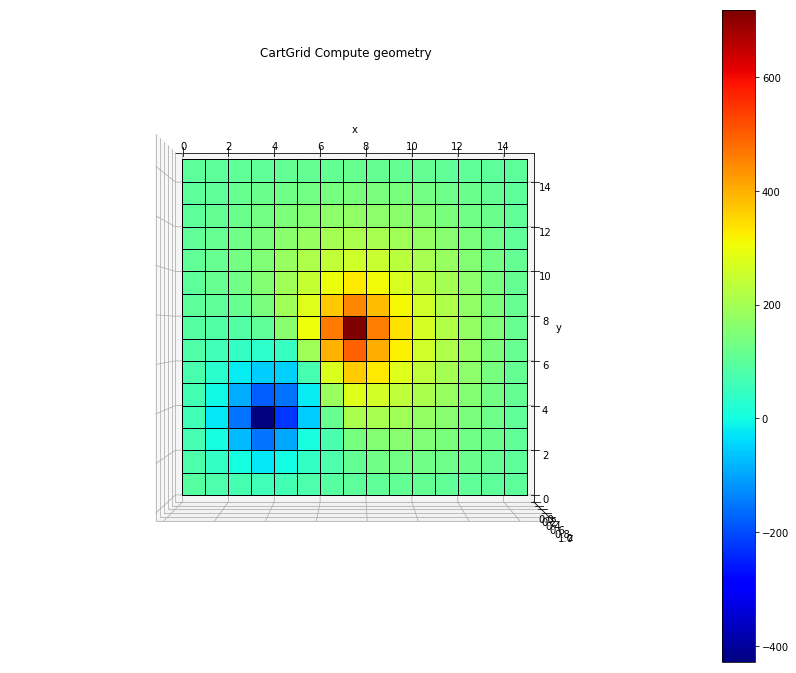

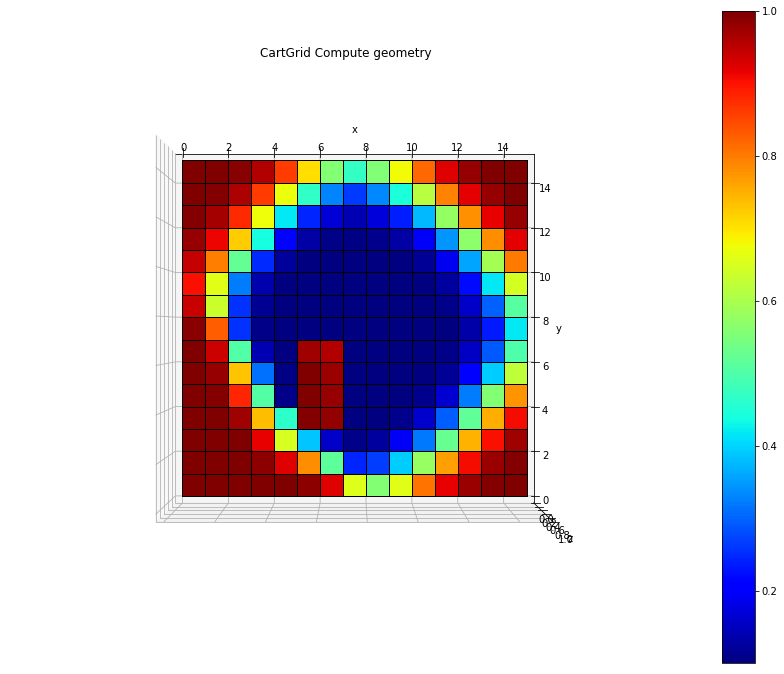

In [68]:
t = np.ones(g.num_cells)

#A_diff, b_diff = diffusion_discretizer.matrix_rhs(g, data)

for timestep in range(n_steps):
    f[g.tags['production_cell']] = t[g.tags['production_cell']] * production_volume
    A_adv, b_adv = advection_discretizer.matrix_rhs(g, data)
    _, b_source = source_discretizer.matrix_rhs(g, data)
    lhs = M
    rhs = (M - A_adv) * t + b_adv + b_source
    t = sps.linalg.spsolve(lhs, rhs)
    
plot_grid(g, p, figsize=(15, 12))
plot_grid(g, t, figsize=(15, 12))

Repeat the transport simulation with diffusion.

/home/ivar/anaconda3/envs/pore/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


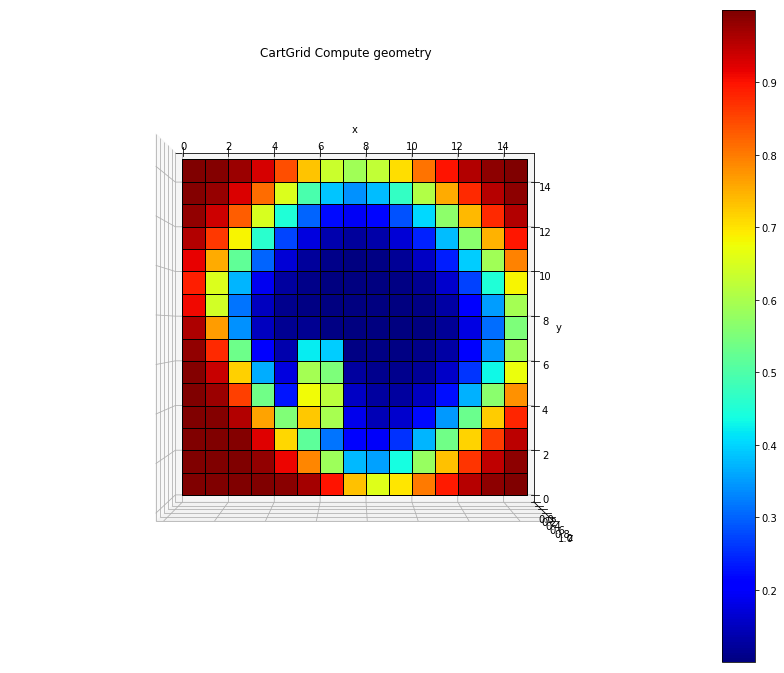

In [69]:
t = np.ones(g.num_cells)
A_diff, b_diff = diffusion_discretizer.matrix_rhs(g, data)

for timestep in range(n_steps):
    f[g.tags['production_cell']] = t[g.tags['production_cell']] *production_volume
    A_adv, b_adv = advection_discretizer.matrix_rhs(g, data)
    _, b_source = source_discretizer.matrix_rhs(g, data)
    lhs = M
    rhs = (M - A_adv - A_diff) * t + b_adv + b_source + b_diff
    t = sps.linalg.spsolve(lhs, rhs)   

plot_grid(g, t, figsize=(15, 12))

## A shortcut using models
**PorePy** comes with a couple of "models" for solving specific physical problems. One of these models is set up for the purely advective problem solved above. We will now demonstrate how it may be used. Note that we

In [70]:
from porepy.numerics.elliptic import EllipticModel, EllipticDataAssigner
from porepy.numerics.darcy_and_transport import DarcyAndTransport, \
static_flow_IE_solver
from porepy.numerics.parabolic import ParabolicModel, ParabolicDataAssigner

In [71]:
def IE_Discretizer(static_flow_IE_solver):
    def __init__(self, problem):
        static_flow_IE_solver.__init__(self, problem)
        
    def step(self, solver):
        _, rhs_flux = self._discretize(self.space_disc)
        self.p = solver(self.lhs_time * self.p0 + self.rhs_time + rhs_flux)

In [90]:
class FlowData(EllipticDataAssigner):
    """
    Assign flow problem data to a given grid.
    The parameters for which we want other values than
    the EllipticDataAssigner defaults are set by overwriting the
    corresponding function.
    """

    def __init__(self, g, d):
        EllipticDataAssigner.__init__(self, g, d)

   
    def permeability(self):
        return perm

    def bc(self):
        return bc_flow

    def source(self):
        return f_flow

    def bc_val(self):
        return bc_values_flow


class TransportData(ParabolicDataAssigner):
    """
    Assign transport problem data to given grid.
    """

    def __init__(self, g, d):
        ParabolicDataAssigner.__init__(self, g, d)

    def bc(self):
        return bc

    def bc_val(self, t):
        return bc_values

    def source(self, t):
        return f

    
class TransportSolver(ParabolicModel):
    """
    Make a ParabolicModel for the transport problem with specified parameters.
    """

    def __init__(self, g, d, kw):
        self._g = g
        transport_data = {'transport_data': d}
        kw['data'] = transport_data
        kw['time_step'] = data['deltaT']
        
        ParabolicModel.__init__(self, g, **kw)
        self._solver.parameters['store_results'] = True

    def grid(self):
        return self._g

    def space_disc(self):
        return self.advective_disc(), self.source_disc()

    def time_step(self):
        return data['deltaT']

    def end_time(self):
        return data['deltaT'] * n_steps

    def solver(self):
        return IE_Discretizer(self)

    
class BothProblems(DarcyAndTransport):
    """
    Combine the two problems for convinience.
    """

    def __init__(self, g, d):
        flow, transport = self.setup_subproblems(g, d)
        DarcyAndTransport.__init__(self, flow, transport)

    def setup_subproblems(self, g, d):

        kw = {'folder_name': 'transport_tutorial'}
        flow_d = FlowData(g, d)

        darcy_problem = EllipticModel(g, flow_d, **kw)
        transport_d = TransportData(g, d)._data
        transport_problem = TransportSolver(g, transport_d, kw)
        return darcy_problem, transport_problem

    def solve_and_save(self):
        self.transport._solver.data['transport'] = []
        self.transport._solver.data['times'] = []
        p, t = self.solve()
        self.save(export_every=20)
        return p, t

In [91]:
# Problems = BothProblems(g, data)

AttributeError: 'NoneType' object has no attribute 'parameters'